In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch
import numpy as np
from CKA import CKA, CudaCKA
import pprint
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Tuple

device = torch.device('cuda')
cuda_cka = CudaCKA(device)

/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
cd /projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/

/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training


In [4]:
### Prepare data


def get_cifar100_train_test_loaders(batch_size):
    mean, std = [x / 255 for x in [129.3, 124.1, 112.4]], [x / 255 for x in [68.2, 65.4, 70.4]]
    dataset = dset.CIFAR100
    num_classes = 100
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(), transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    train_data = dataset("../image_classification/data", train=True,
                                    transform=train_transform, 
                                    download=True)
    test_data = dataset("../image_classification/data", train=False,
                    transform=test_transform, 
                    download=True)
    train_loader = torch.utils.data.DataLoader(
                    train_data, batch_size=batch_size, shuffle=True,
                    num_workers=2, pin_memory=True, )
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=
        batch_size, shuffle=True,
        num_workers=2, pin_memory=True)

    return train_loader, test_loader

batch_size = 200
train_loader, test_loader = get_cifar100_train_test_loaders(batch_size)

device = torch.device("cuda")
samples =  iter(test_loader) # iter(train_loader)
img, labels  = samples.next()
img, labels = img.to(device), labels.to(device)
img.shape, labels.shape



Files already downloaded and verified
Files already downloaded and verified


(torch.Size([200, 3, 32, 32]), torch.Size([200]))

In [5]:
# folder = "target_100epochs"
# epoch = 10
# model =  torch.load(f"{folder}/net_epoch{epoch}.pt").module
# model

In [6]:
import tensorflow as tf
from growneuron.cifar import wide_resnet
from growneuron.layers import GrowLayer
def call_tf(i):
    pytorch_tensor = img.permute(0,2,3,1)
    np_tensor = pytorch_tensor.cpu().numpy()
    img_tf = tf.convert_to_tensor(np_tensor)

    def call(model, inputs):
        x = model.conv_stem(inputs)
        store = [x.numpy()]

        for i, block_seq in enumerate(model.group_seq):
            for block_layers, skip_layer in block_seq:
                y = x
                # Main branch.
                count = 0
                for layer in block_layers:
                
                    y = layer(y)
                    if isinstance(layer, GrowLayer):
                        store.append(y.numpy().copy())
                        count+=1
                # Skip branch
                
                
                if skip_layer:
                    x = skip_layer(x)
                    store.append(x.numpy().copy())
                    count+=1
                print(count)
                x = x + y

        for layer in model.final_layers:
            x = layer(x)

        store.append( x.numpy())
#         store = store[:3] + store[4:]

        return x, store

    model = wide_resnet.create_model(num_classes=100, depth=28, width_multiplier=10, block_width_multiplier=1 if i > 44 else 0.25,  normalization_type="none")
    dummy_optimizer = tf.keras.optimizers.SGD(0.1)
    latest_checkpoint = f"growneuron/outputs/cifar/save_16422_single/gm_random_cifar/checkpoint-{i}"
    print(latest_checkpoint)
    checkpoint = tf.train.Checkpoint(model=model)
    stat = checkpoint.restore(latest_checkpoint)
    stat.assert_existing_objects_matched()
    _, out = call(model, img_tf)
    len(out)
    return out
    
    
    
    
def forward_all_layers(model, x, layer=None, verbose=False):
    def block_forward(model, x, len_store):
        residual = x
        out = model.relu(model.bn1(x))
        
        if not model.equalInOut: residual = out
        out_conv_1 = model.conv1(out)
        out_conv_2 = model.conv2(model.relu(model.bn2(out_conv_1)))
#         if model.convShortcut is not None: 
#             residual = model.convShortcut(residual)
#             out_conv_shortcut = residual
#             block_store = [out_conv_1, out_conv_2, out_conv_shortcut]
#         else:
#             block_store = [out_conv_1, out_conv_2]

        if model.convShortcut is not None: 
            residual = model.convShortcut(residual)
            out_conv_shortcut = residual
            block_store = [out_conv_1.clone(), out_conv_2.clone(), out_conv_shortcut.clone()]
        elif len_store == 1:
            out_conv_shortcut = residual
            block_store = [out_conv_1.clone(), out_conv_2.clone(), out_conv_shortcut.clone()]
        else:
            block_store = [out_conv_1.clone(), out_conv_2.clone()]
        return out_conv_2 + residual, block_store
    
    
    store = []
    out = model.conv_3x3(x)
    if verbose:
        print("conv stem", 1)
            
    store.append(out)
    
    # (4 * 2 + 1)  * 3
    for stage in [model.stage_1, model.stage_2, model.stage_3]:
        for block in stage:
            len_store = len(store)
            out, block_store = block_forward(block, out, len_store)
            store.extend(block_store)
            if verbose:
                print("len(block_store)", len(block_store))
        
        
    out = model.lastact(out)
    out = model.avgpool(out)
    
    out = out.view(out.size(0), -1)
    
    out = model.classifier(out)
    store.append(out)
    
    del model
    if verbose:
        print("num layers:", len(store))
    return store



def plot_heatmap_by_layer(folders, epochs, model_types: Tuple[str, str],  batch_size,  method = "linear_CKA", verbose=False, num_students=2):
    
    """
        folder: for example, ["ours_ens_grow_63", "ours_ens_grow_63"]
        model_types: a Tuple contains 2 strings: the string is one of ["student_1", "student_2", "teacher"]. E.g., ("student_1", "student_2")
        method: linear_KCA or kernel_CKA
    """
    def get_store(folder, img, model_type: str, verbose: bool, epoch):
        print('epoch=', epoch)
        model = None
        if "ours" in folder:
            if "ours_ens" in folder:
                print("calling ours_ens...")
            else:
                print("calling ours (w/out ens)...")
            
            if model_type == "student_1":
                print("student 1")
                model = torch.load(f"{folder}/student_net_epoch{epoch}_1_of_{num_students}.pt").module
            elif model_type == "student_2":
                print("student 2")

                model = torch.load(f"{folder}/student_net_epoch{epoch}_2_of_{num_students}.pt").module
            else:
                print("teacher")
                model =  torch.load(f"{folder}/net_epoch{epoch}.pt").module
            store = forward_all_layers(model, img, verbose=verbose)
        
        elif "target" in folder:
            print("calling target...")
            model =  torch.load(f"{folder}/net_epoch{epoch}.pt").module
            store = forward_all_layers(model, img, verbose=verbose)
        
        elif "random" in model_type:
            print("call random (tf)...")
            store = call_tf(epoch)
        if model is not None:
            del model

        return store
    
    
    def reshape_tensor(raw_X, is_tf):
        if is_tf:
            X = torch.from_numpy(raw_X)
            if len(X.shape) == 4:
                X = X.permute(0,3,1,2).reshape(batch_size, -1).to("cuda")
            else:
                assert len(X.shape) == 2
                X = X.reshape(batch_size, -1).to("cuda")
        else:
            X = raw_X.reshape(batch_size, -1)
        return X
        
    if isinstance(epochs, list):
        epoch_1, epoch_2 = epochs
    else:
        epoch_1 =  epoch_2 = epochs
        
    store_1 = get_store(folders[0], img, model_types[0], verbose, epoch=epoch_1)
    store_2 = get_store(folders[1], img, model_types[1], verbose, epoch=epoch_2)
    
    assert len(store_1) == len(store_2)
    num_layers = len(store_2)

    data = np.zeros((num_layers, num_layers))
    
    for i in range(num_layers):
        for j in range(i, num_layers):
            X = reshape_tensor(store_1[i], model_types[0] == "random")
            Y = reshape_tensor(store_2[j], model_types[1] == "random")
            
            ## Compute CKA
            cor = cuda_cka.linear_CKA(X, Y) if method=="linear_CKA" else cuda_cka.kernel_CKA(X, Y)
            
            ## store the result in `data`
            data[i][j] = cor
            
        
    data = data.T + data - np.identity(num_layers)  ## fill in the other half
    s = sns.heatmap(data, vmin=0, vmax=1) ## plot heatmap
    s.set(xlabel= folders[0] + " " + model_types[0] +"'s layer", 
          ylabel=folders[1] + " " + model_types[1] + "'s layer",
         title="epoch="+str(epochs))
    del store_1
    del store_2
    del data



epoch= 99
call random (tf)...
growneuron/outputs/cifar/save_16422_single/gm_random_cifar/checkpoint-99
3
2
2
2
3
2
2
2
3
2
2
2


epoch= 99
call random (tf)...
growneuron/outputs/cifar/save_16422_single/gm_random_cifar/checkpoint-99
3
2
2
2
3
2
2
2
3
2
2
2


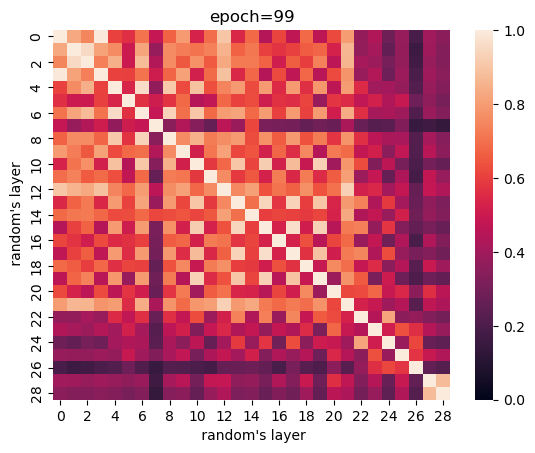

In [7]:
data = plot_heatmap_by_layer(folders = ["",  ""], batch_size=batch_size,
                             epochs=99, model_types=["random", "random"], verbose=True)



In [16]:
#gc.collect()
torch.cuda.empty_cache()

In [17]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([200, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([160, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([5, 57600])
<class 'torch.Tensor'> torch.Size([5, 1])
<class 'torch.Tensor'> torch.Size([5, 57600])
<class 'torch.Tensor'> torch.Size([5, 1])
<class 'torch.Tensor'> torch.Size([5, 57600])
<class 'torch.Tensor'> torch.Size([5, 1])
<class 'torch.Tensor'> torch.Size([5, 57600])
<class 'torch.Tensor'> torch.Size([5, 1])
<class 'torch.Tensor'> torch.Size([200, 160, 32, 32])
<class 'torch.Tensor'> torch.Size([200, 160, 32, 32])
<class 'torch.Tensor'> to

/scratch/8418232.1.ivcbuyin/ipykernel_112561/1346771883.py:5: DeprecationWarning: 'utils.HTMLBuilder' is deprecated and will be removed in Werkzeug 2.1.
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


In [10]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  ""], batch_size=batch_size,
                             epochs=99, model_types=["teacher", "random"], verbose=True)



epoch= 99
calling ours_ens...
teacher
conv stem 1


RuntimeError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 23.65 GiB total capacity; 394.61 MiB already allocated; 120.19 MiB free; 422.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "target_100epochs"], batch_size=batch_size,
                             epochs=99, model_types=["teacher", "target"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=99, model_types=["teacher", "student_1"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=99, model_types=["teacher", "student_2"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=62, model_types=["student_1", "student_2"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=[62, 62], model_types=["student_2", "student_2"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=[62, 62], model_types=["student_1", "student_1"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=99, model_types=["student_1", "student_1"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=[99, 62], model_types=["teacher", "student_1"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_ens_grow_63",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=[99, 62], model_types=["teacher", "student_2"], verbose=False)



In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_grow_42",  "ours_ens_grow_63"], batch_size=batch_size,
                             epochs=[99, 99], model_types=["teacher", "teacher"], verbose=False, num_students=2)




In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_grow_42",  "ours_grow_42"], batch_size=batch_size, method="kernel_CKA",
                             epochs=[99, 41], model_types=["teacher", "student_1"], verbose=False, num_students=1)


In [ ]:
data = plot_heatmap_by_layer(folders = ["ours_grow_42",  "ours_grow_42"], batch_size=batch_size, method="linear_CKA",
                             epochs=[99, 41], model_types=["teacher", "student_1"], verbose=False, num_students=1)
